## Importeren van Bibliotheken

In [3]:
import pandas
import numpy
import sqlite3 as sql
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Inlezen van de Data

In [4]:
conn = sql.connect("../data/go_sales_train.sqlite")
print(conn)

## Aanmaken van de dataframe

In [5]:
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
table_names = pandas.read_sql(tables_query, conn)['name']

def get_dataframe(table_name):
    dataframe = pandas.read_sql(f"SELECT * FROM {table_name}", conn)
    return dataframe

table_names

0           country
1     order_details
2      order_header
3      order_method
4           product
5      product_line
6      product_type
7     retailer_site
8     return_reason
9     returned_item
10     sales_branch
11      sales_staff
Name: name, dtype: object

## Aanmaken van de dataframes & Kolommen selecteren

In [6]:
df_order_header = get_dataframe('order_header')
df_order_details = get_dataframe('order_details')
df_returned_item = get_dataframe('returned_item')
df_return_reason = get_dataframe('return_reason')

merged_dataframe = pandas.merge(
    df_order_details,
    df_order_header[['ORDER_NUMBER', 'SALES_BRANCH_CODE']],
    on='ORDER_NUMBER',
    how='left'
)

merged_dataframe = pandas.merge(
    merged_dataframe,
    df_returned_item[['ORDER_DETAIL_CODE', 'RETURN_QUANTITY', 'RETURN_REASON_CODE']],
    on='ORDER_DETAIL_CODE',
    how='left'
)

merged_dataframe = pandas.merge(
    merged_dataframe,
    df_return_reason,
    on='RETURN_REASON_CODE',
    how='left'
)

merged_dataframe['RETURN_REASON_CODE'] = merged_dataframe['RETURN_REASON_CODE'].dropna()

model_dataframe = merged_dataframe.loc[:,['SALES_BRANCH_CODE', 'RETURN_REASON_CODE', 'UNIT_PRICE']]
model_dataframe = model_dataframe.dropna()
model_dataframe

,SALES_BRANCH_CODE,RETURN_REASON_CODE,UNIT_PRICE
6,18,3.0,6.59
18,18,2.0,12.53
30,18,2.0,7.32
39,18,3.0,54.93
46,18,4.0,129.72
...,...,...,...
37631,30,2.0,529.98
37656,30,1.0,13.50
37657,30,2.0,15.00
37686,30,1.0,20.00


In [7]:
model_dataframe.dtypes

SALES_BRANCH_CODE       int64
RETURN_REASON_CODE    float64
UNIT_PRICE            float64
dtype: object

## Horizontaal en verticaal snijden

In [8]:
# X = model_dataframe.loc[model_dataframe['SALES_BRANCH_CODE'].notna(), :]
# X = X.drop(['SALES_BRANCH_CODE', 'UNIT_PRICE'], axis = 1)
# y = model_dataframe.loc[model_dataframe['SALES_BRANCH_CODE'].notna(), ['SALES_BRANCH_CODE', 'UNIT_PRICE']]
# y.info()

X = model_dataframe.drop('RETURN_REASON_CODE', axis = 1)
y = model_dataframe.loc[:, ['RETURN_REASON_CODE', ]]
X

,SALES_BRANCH_CODE,UNIT_PRICE
6,18,6.59
18,18,12.53
30,18,7.32
39,18,54.93
46,18,129.72
...,...,...
37631,30,529.98
37656,30,13.50
37657,30,15.00
37686,30,20.00


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.15, 
    random_state=42
)

## Regressiemodel bouwen

In [10]:
list(y.columns)

['RETURN_REASON_CODE']

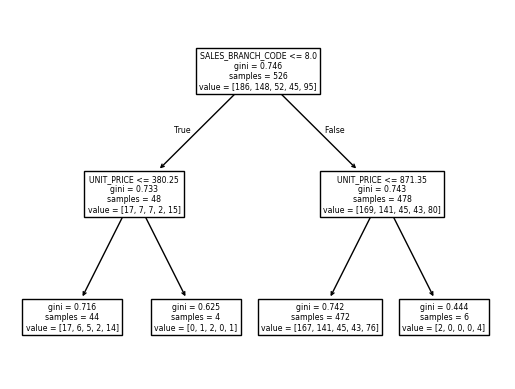

In [11]:
dtree = DecisionTreeClassifier(max_depth = 2)
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [12]:
predicted_df = pandas.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'Predicted_Reason'})
model_results_frame = pandas.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis = 1)
model_results_frame

,RETURN_REASON_CODE,Predicted_Reason
0,3.0,1.0
1,3.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
88,2.0,1.0
89,1.0,1.0
90,1.0,1.0
91,1.0,1.0


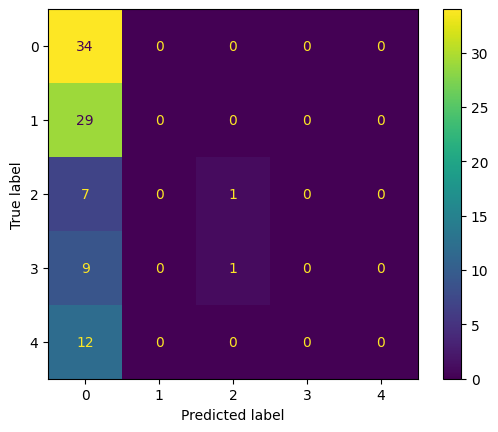

In [13]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [14]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Reason'])

0.3763440860215054